In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sys import stdout

from network import HandModel
from process_data import get_data_set, get_num_batches


2025-07-15 12:51:09.112617: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-15 12:51:09.125567: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-15 12:51:09.129593: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-15 12:51:09.139982: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
model = HandModel()
completedEpochs = 25
dummy_input = tf.random.normal([1, 368, 368, 3])
_ = model(dummy_input)

model.load_weights('good progress models/vgg19_train_full_dataset3.h5')

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

train_loss = tf.keras.metrics.Mean(name='train_loss')

train_data, val_data = get_data_set()
num_batches = get_num_batches()

I0000 00:00:1752609077.058817  857164 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1752609077.104394  857164 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1752609077.110672  857164 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1752609077.114571  857164 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [3]:
def compute_loss(y_pred, intermediate_pred, y):
    loss_object = tf.keras.losses.MeanSquaredError()
    final_loss = loss_object(y, y_pred)
    total_loss = final_loss
    for y_hat in intermediate_pred:
        total_loss += 0.5 * loss_object(y, y_hat)
    
    return final_loss, total_loss

In [4]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        y_pred, y_intermediate = model(x)
        fin_loss, total_loss = compute_loss(y_pred, y_intermediate, y)

    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return total_loss

In [5]:
try:
        
    for epoch in range(10):
        train_loss.reset_state()


        for batch_num, (x_batch, y_batch) in enumerate(train_data):
            train_loss(train_step(x_batch, y_batch))
            print(f"\rProgress: {batch_num + 1}/{num_batches}", end='', flush=True)

        print()

        curr_loss = train_loss.result()

        print(f"Epoch {epoch + 1} ----- Loss: {curr_loss}")

        if curr_loss < 0.0001:
            print("Finished training, ended early")
            break
except KeyboardInterrupt:
    print("Stopping Training, saving weights")
    model.save("vgg19_train_full_dataset.h5")


W0000 00:00:1752609116.065538  857420 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1752609116.067763  857420 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1752609116.070834  857420 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1752609116.073630  857420 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1752609116.076004  857420 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1752609116.079316  857420 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1752609116.081903  857420 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1752609116.084915  857420 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1752609116.090316  857420 gp

Progress: 1/210

W0000 00:00:1752609123.470806  857420 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1752609123.475885  857420 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1752609123.494786  857420 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1752609123.502215  857420 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


Progress: 209/210

W0000 00:00:1752609680.137739  857420 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1752609680.139321  857420 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1752609680.140970  857420 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1752609680.142623  857420 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1752609680.144281  857420 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1752609680.146540  857420 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1752609680.148334  857420 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1752609680.150156  857420 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1752609680.153037  857420 gp

Progress: 210/210

W0000 00:00:1752609684.908585  857420 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
2025-07-15 13:01:24.917410: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 1 ----- Loss: 0.0039475224912166595
Progress: 210/210


2025-07-15 13:10:46.848681: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2 ----- Loss: 0.003625391749665141
Progress: 210/210
Epoch 3 ----- Loss: 0.0035223490558564663
Progress: 210/210


2025-07-15 13:29:59.877030: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4 ----- Loss: 0.0034687186125665903
Progress: 210/210
Epoch 5 ----- Loss: 0.003329005092382431
Progress: 210/210
Epoch 6 ----- Loss: 0.003190811490640044
Progress: 210/210
Epoch 7 ----- Loss: 0.003125895280390978
Progress: 210/210


2025-07-15 14:08:42.453843: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 8 ----- Loss: 0.0030065542086958885
Progress: 210/210
Epoch 9 ----- Loss: 0.0028966946993023157
Progress: 210/210
Epoch 10 ----- Loss: 0.002787548117339611


In [6]:
model.save("vgg19_train_full_dataset4.h5")

In [7]:
from visualize_data import visualize_combined_map
from process_data import load_img_and_pos_with_num, create_heat_map

In [8]:
dummy_input = tf.random.normal((1, 368, 368, 3))
model1 = HandModel()
model1(dummy_input)
model1.load_weights("good progress models/vgg19_train_full_dataset2.h5")
model2 = HandModel()
model2(dummy_input)
model2.load_weights("good progress models/vgg19_train_full_dataset4.h5")

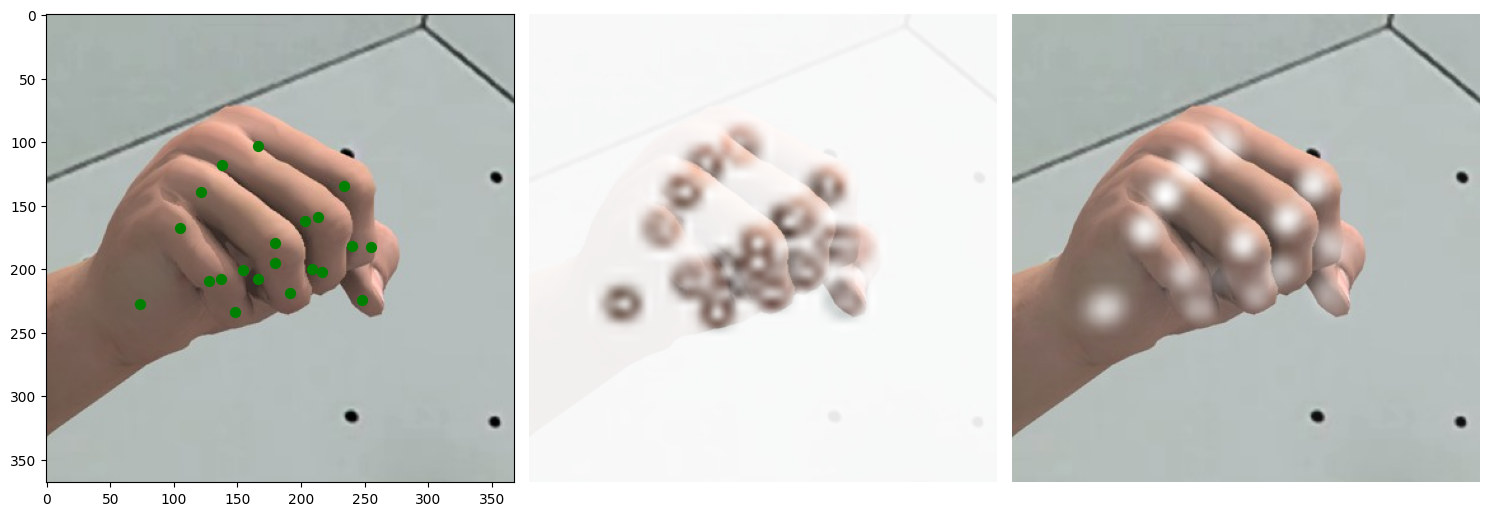

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15,15))

index = np.random.randint(3000)

test_x, test_handpos, _ = load_img_and_pos_with_num(index)
test_y = create_heat_map(test_handpos)

test_x = np.expand_dims(test_x, axis = 0)

y_pred, _ = model2(test_x)

test_handpos = test_handpos.T
axes[0].imshow(test_x[0])
axes[0].scatter(test_handpos[0], test_handpos[1], color='green', s=50)
test_handpos = test_handpos.T

visualize_combined_map(test_x[0], test_y, axes[1])
visualize_combined_map(test_x[0], y_pred[0, :, :, :-1], axes[2])


plt.tight_layout()
plt.show()

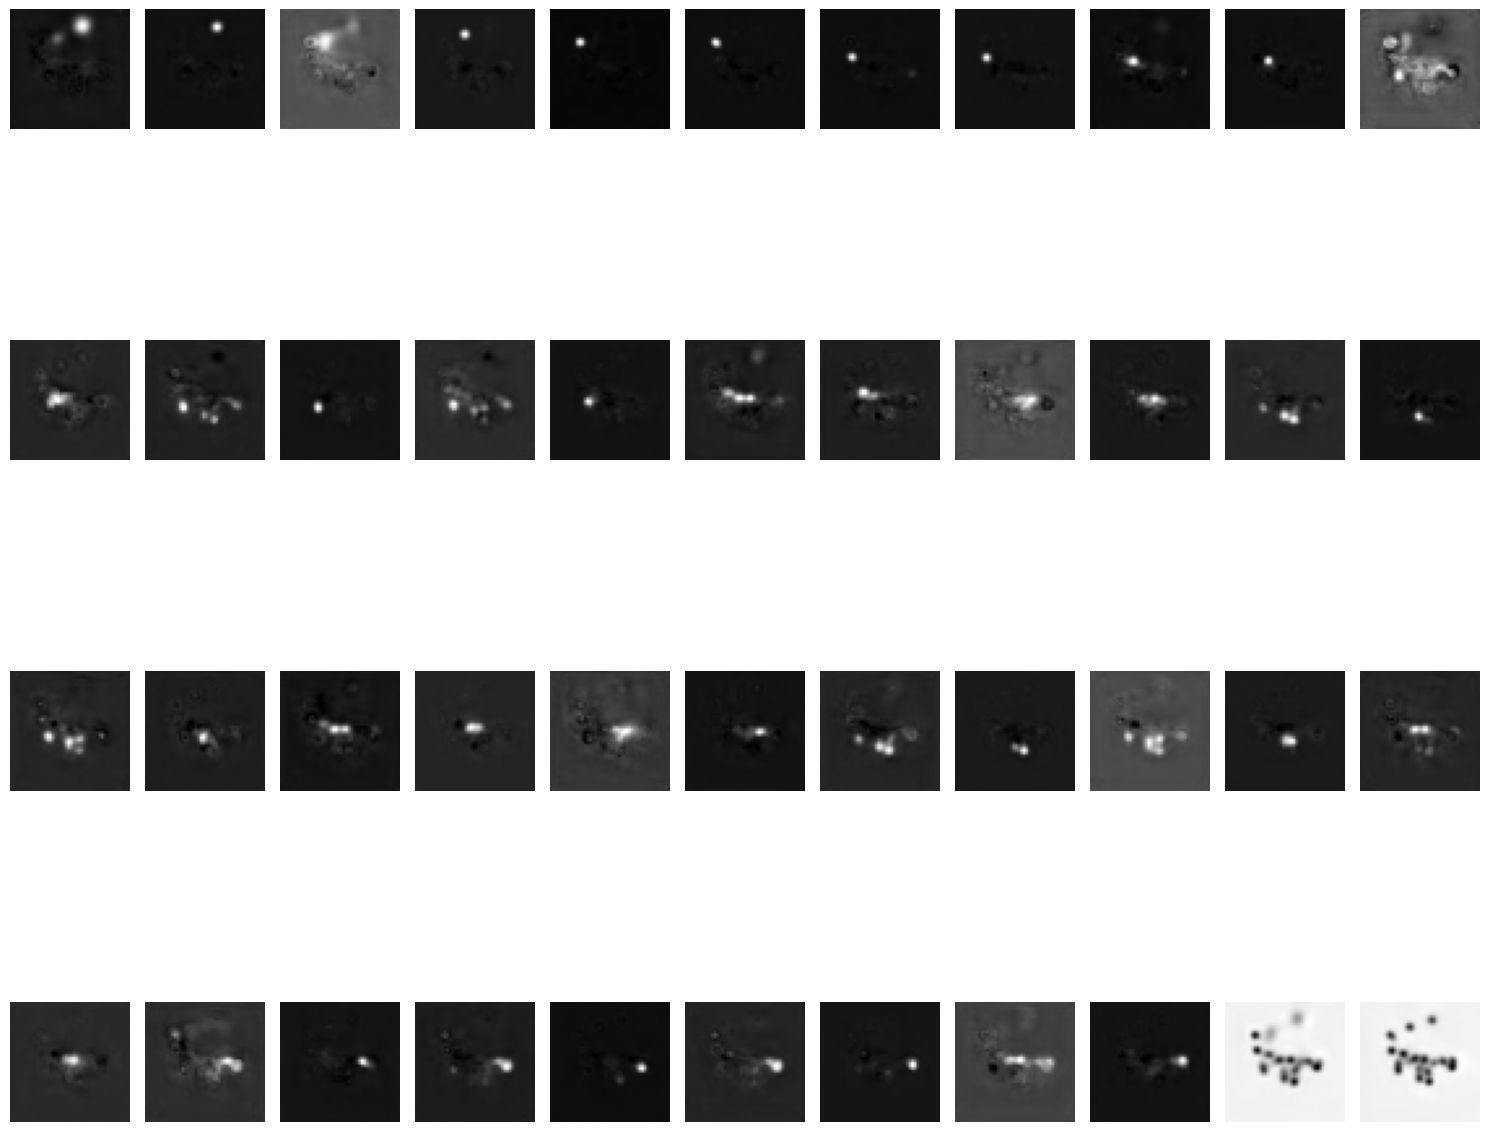

In [ ]:
fig, axes = plt.subplots(4, 11, figsize=(15,15))

index = np.random.randint(3000)

test_x, test_handpos, _ = load_img_and_pos_with_num(index)
test_y = create_heat_map(test_handpos)

test_x = np.expand_dims(test_x, axis = 0)

y_pred1, _ = model1(test_x)
y_pred2, _ = model2(test_x)


for i, ax in enumerate(list(axes.flat)):
    if i%2 == 0:
        ax.imshow(y_pred1[0, :, :, i//2], cmap='gray')
    else:
        ax.imshow(y_pred2[0, :, :, i//2], cmap='gray')
    
    ax.axis('off')


plt.tight_layout()
plt.show()

In [18]:
import matplotlib.image as img

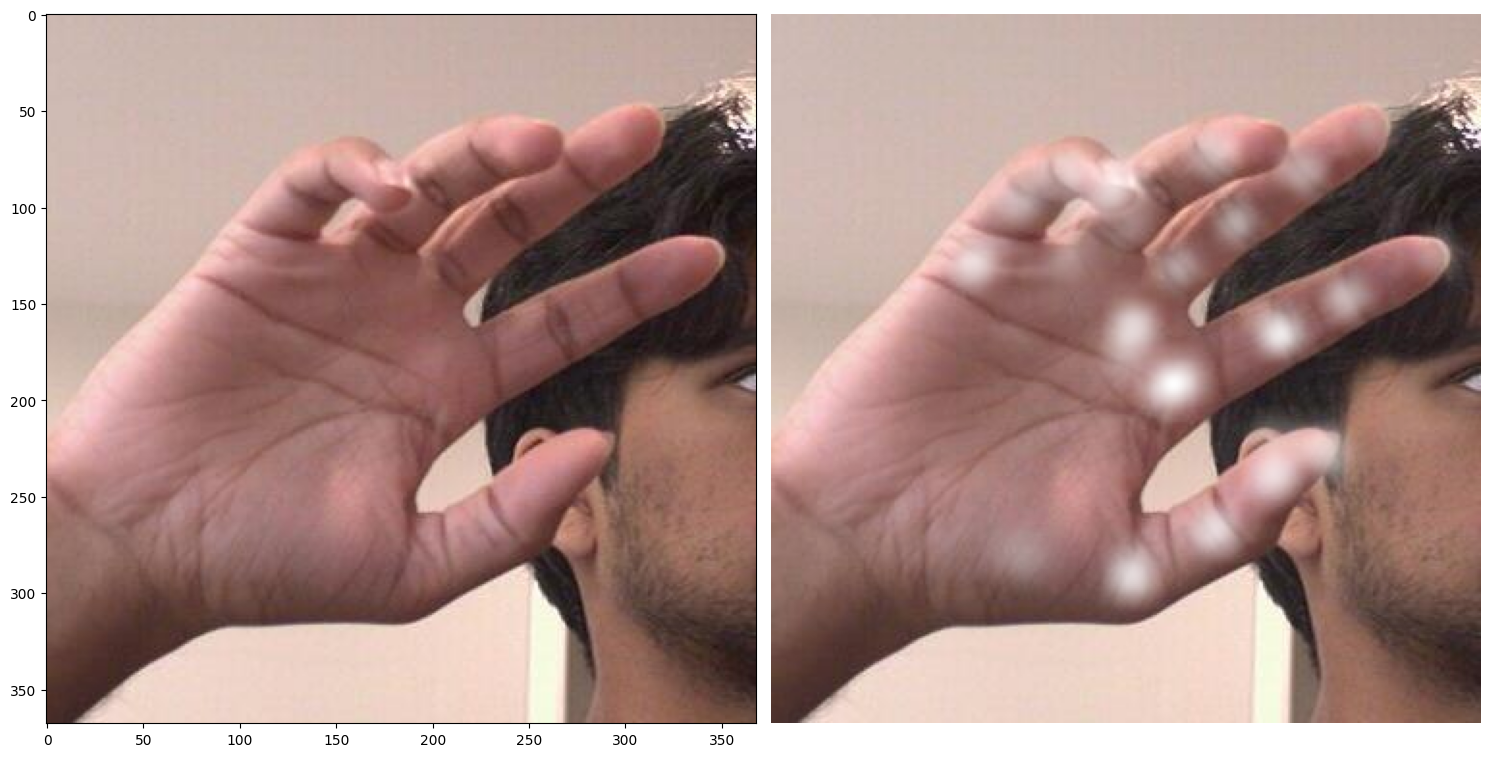

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(15,15))

img_path = "Photo from 2025-07-15 14-54-47.941512.jpeg"

test_x = img.imread(img_path)

test_x = np.expand_dims(test_x, axis = 0)

y_pred, _ = model2(test_x)

axes[0].imshow(test_x[0])

visualize_combined_map(test_x[0], y_pred[0, :, :, :-1], axes[1])


plt.tight_layout()
plt.show()

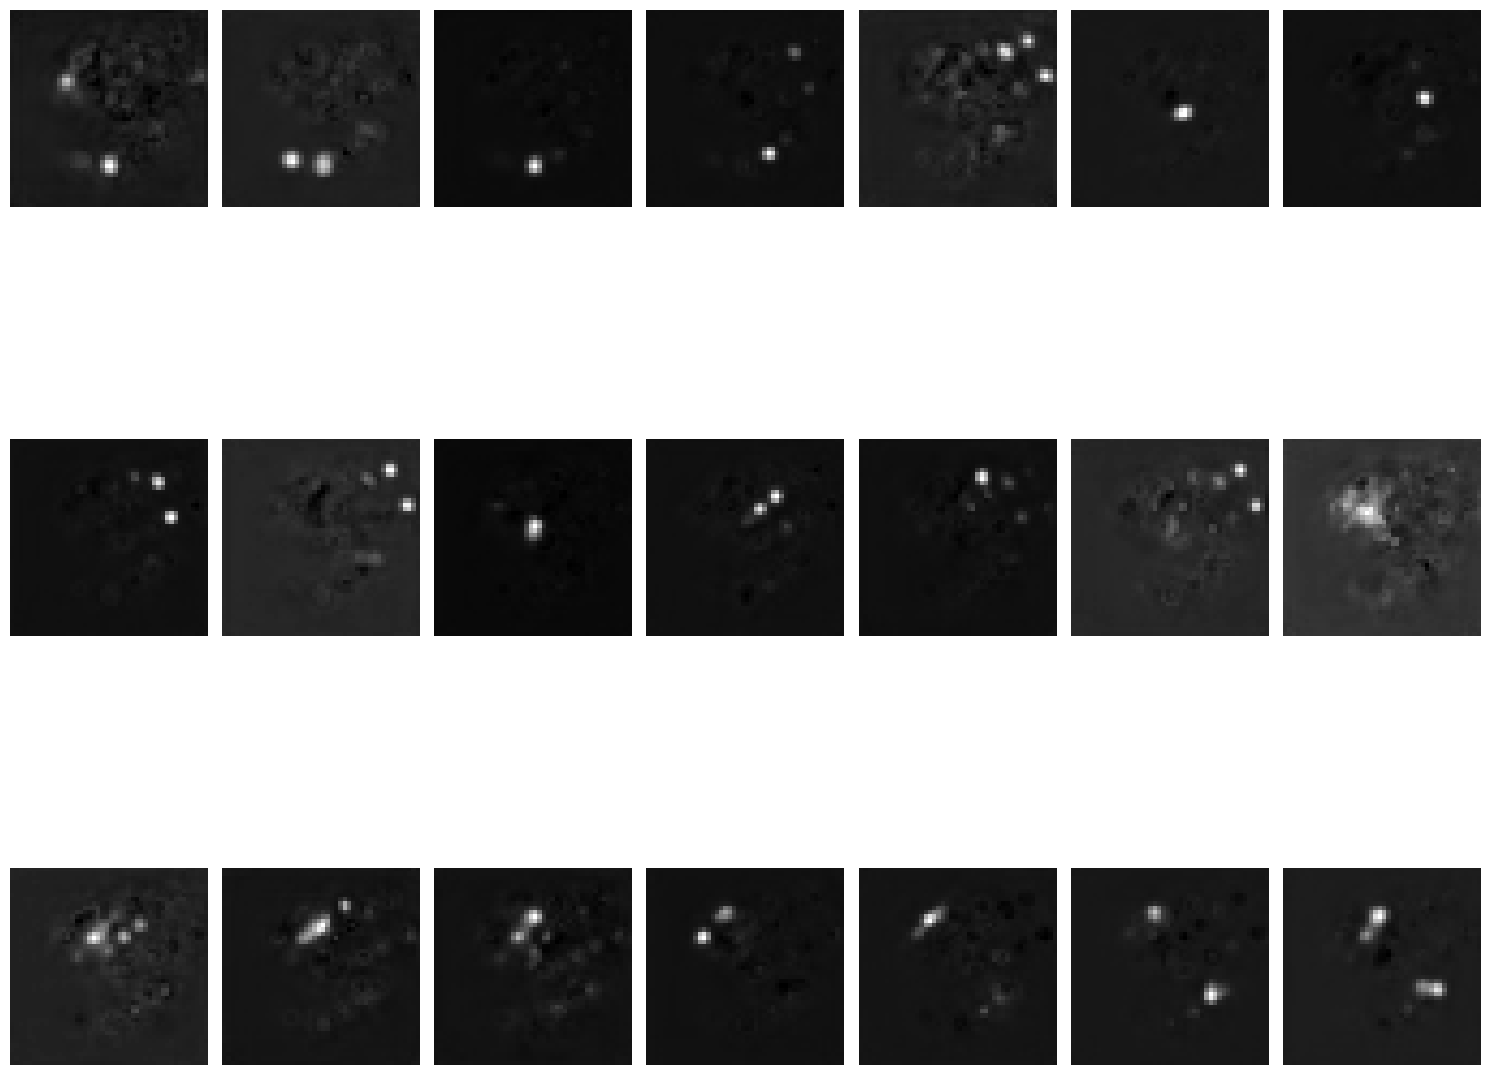

In [21]:
fig, axes = plt.subplots(3, 7, figsize=(15,15))

for i, ax in enumerate(list(axes.flat)):
    ax.imshow(y_pred[0, :, :, i], cmap='gray')
    
    ax.axis('off')


plt.tight_layout()
plt.show()